In [1]:
!pip -q install instructor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.8/358.8 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 143.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 155.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 45.3 MB/s eta 0:00:00


In [ ]:
import getpass
import os
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from enum import Enum
from pathlib import Path
from typing import Any, List, Tuple, Type

import instructor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import torch
from dotenv import load_dotenv
from google.colab import userdata
from openai import OpenAI
from pydantic import BaseModel, Field
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from transformers import pipeline

In [4]:
# Secure API Key Handling
try:
    HF_TOKEN = userdata.get("HF_TOKEN")
except Exception:
    HF_TOKEN = getpass.getpass("Enter HuggingFace API Token: ")

In [5]:
# Secure API Key Handling
try:
    OR_API_KEY = userdata.get("OPEN_ROUTER")
except Exception:
    OR_API_KEY = getpass.getpass("Enter OpenRouter API Key: ")

# Initialize the Instructor Client
client = instructor.from_openai(
    OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=OR_API_KEY,
    ),
    mode=instructor.Mode.JSON,
)

In [29]:
try:
    OPEN_AI = userdata.get("OPEN_AI")
except Exception:
    OPEN_AI = getpass.getpass("Enter OpenAI API Key: ")

# Note: We don't need 'base_url' for OpenAI native
client_native = instructor.from_openai(
    OpenAI(api_key=OPEN_AI),
    mode=instructor.Mode.JSON,
)

In [ ]:
# Load environment variables from .env file
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
	print("Error: OPENAI_API_KEY not found.")

OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
if not OPENROUTER_API_KEY:
	print("Error: OPENROUTER_API_KEY not found.")

HUGGINGFACE_TOKEN = os.getenv("OPENROUTER_API_KEY")
if not HUGGINGFACE_TOKEN:
	print("Error: HUGGINGFACE_TOKEN not found.")

In [10]:
# Path to cleaned dataset (colab-friendly)
books_path = Path("/content/data/books_cleaned.csv")

# load the cleaned dataset
books = pd.read_csv(books_path)
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


In [11]:
category_mapping = {
	"Fiction": "Fiction",
	"Juvenile Fiction": "Children's Fiction",
	"Biography & Autobiography": "Nonfiction",
	"History": "Nonfiction",
	"Literary Criticism": "Nonfiction",
	"Philosophy": "Nonfiction",
	"Religion": "Nonfiction",
	"Comics & Graphic Novels": "Fiction",
	"Drama": "Fiction",
	"Juvenile Nonfiction": "Children's Nonfiction",
	"Science": "Nonfiction",
	"Poetry": "Fiction",
}

books["simple_categories"] = books["categories"].map(category_mapping)

In [12]:
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,NaN
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,NaN
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",NaN


In [ ]:
class BookCategory(str, Enum):
    """Strict enumeration to prevent model hallucination."""
    FICTION = "Fiction"
    NONFICTION = "Nonfiction"


class BookClassification(BaseModel):
    category: BookCategory


class BookClassificationReasoning(BaseModel):
    reasoning: str = Field(..., description="Explain WHY this book fits the category based on the description.")
    category: BookCategory

In [ ]:
def classify_description(
    text: str,
    model: str,
    response_model: Type[BaseModel]
) -> str:
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "Classify this book description. Provide reasoning first."
                },
                {"role": "user", "content": text},
            ],
            response_model=response_model,
            temperature=0.0,
            max_retries=2,
        )
        return response.category.value
    except Exception:
        return "Error"


def classify_with_native(text: str, model: str, response_model: Type[BaseModel]) -> str:
    try:
        response = client_native.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Classify this book. Think step-by-step."},
                {"role": "user", "content": text},
            ],
            response_model=response_model,
            max_retries=2,
        )
        return response.category.value
    except Exception as e:
        # LOGGING THE ERROR (Fixes the "Silent Failure" bug)
        # print(f"DEBUG: Failed on '{text[:10]}...' with error: {e}")
        return "Error"


def run_batch_classification(
    sequences: List[str],
    label: str,
    model_name: str,
    schema: Type[BaseModel],
    max_workers: int = 15
) -> Tuple[List[str], List[str]]:

    preds = []
    actuals = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # We submit the Flexible Worker with the specific model and schema
        future_to_seq = {
            executor.submit(classify_description, seq, model_name, schema): seq
            for seq in sequences
        }

        desc = f"[{model_name.split('/')[-1]}] Classifying {label}"

        for future in tqdm(as_completed(future_to_seq), total=len(sequences), desc=desc):
            try:
                result = future.result()
                preds.append(result)
                actuals.append(label)
            except Exception:
                preds.append("Error")
                actuals.append(label)

    return preds, actuals


def run_native_batch(sequences, label, model_name, schema, max_workers=15):
    preds = []
    actuals = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_seq = {
            executor.submit(classify_with_native, seq, model_name, schema): seq
            for seq in sequences
        }

        for future in tqdm(as_completed(future_to_seq), total=len(sequences), desc=f"[{model_name}] {label}"):
            try:
                result = future.result()
                preds.append(result)
                actuals.append(label)
            except Exception:
                preds.append("Error")
                actuals.append(label)
    return preds, actuals

In [ ]:
# Configuration for testing accuracy
SUBSET_SIZE = 300

subset_fiction = books[books["simple_categories"] == "Fiction"].sample(n=SUBSET_SIZE, random_state=42)
subset_nonfiction = books[books["simple_categories"] == "Nonfiction"].sample(n=SUBSET_SIZE, random_state=42)

sequences_fic = subset_fiction["description"].tolist()
sequences_non = subset_nonfiction["description"].tolist()

print(f"sequences_fic: {len(sequences_fic)} items")
print(f"sequences_non: {len(sequences_non)} items")

sequences_fic: 300 items
sequences_non: 300 items


In [ ]:
zs_model_name = "MoritzLaurer/deberta-v3-large-zeroshot-v2.0"

print(f"Loading Zero-Shot Model: {zs_model_name}...")
classifier = pipeline(
    "zero-shot-classification",
    model=zs_model_name,
    device=0  # Use GPU
)

hypothesis_template = "This book is strictly {}."
candidate_labels = ["Fiction", "Nonfiction"]


def run_hf_zero_shot(sequences, batch_size=16):
    preds = []

    results_iterator = classifier(
        sequences,
        candidate_labels,
        hypothesis_template=hypothesis_template,
        batch_size=batch_size
    )

    for result in tqdm(results_iterator, total=len(sequences)):
        # The result looks like: {'labels': ['Fiction', 'Nonfiction'], 'scores': [0.99, 0.01]}
        # We take the top label (index 0)
        top_label = result['labels'][0]
        preds.append(top_label)

    return preds


# Run Inference
zs_preds_fic = run_hf_zero_shot(sequences_fic)
zs_preds_non = run_hf_zero_shot(sequences_non)

# Combine
zs_all_preds = zs_preds_fic + zs_preds_non
zs_all_actuals = ["Fiction"] * len(sequences_fic) + ["Nonfiction"] * len(sequences_non)

# Metrics
print("\nClassification Report:\n")
print(f"\n{classification_report(zs_all_actuals, zs_all_preds)}")

Loading Zero-Shot Model: MoritzLaurer/deberta-v3-large-zeroshot-v2.0...


Device set to use cuda:0
100%|██████████| 300/300 [00:00<00:00, 1294538.27it/s]


Classification Report:


              precision    recall  f1-score   support

     Fiction       0.92      0.91      0.91       300
  Nonfiction       0.91      0.92      0.91       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



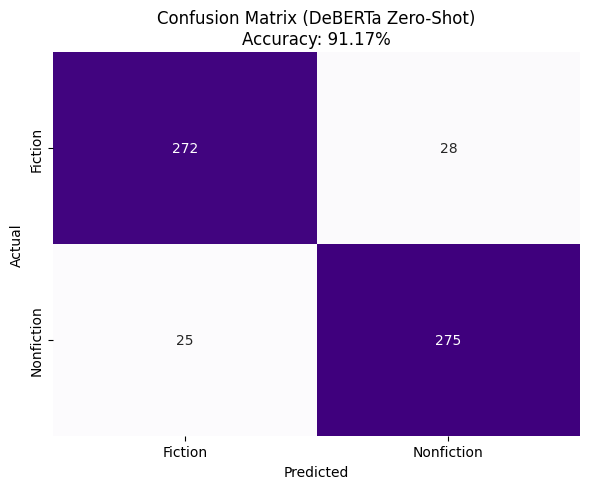

In [ ]:
zs_acc = accuracy_score(zs_all_actuals, zs_all_preds)
zs_cm = confusion_matrix(zs_all_actuals, zs_all_preds, labels=["Fiction", "Nonfiction"])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    zs_cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    cbar=False,
    xticklabels=["Fiction", "Nonfiction"],
    yticklabels=["Fiction", "Nonfiction"]
)
ax.set_title(f"Confusion Matrix (DeBERTa Zero-Shot)\nAccuracy: {zs_acc:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")

plt.tight_layout()
plt.show()

In [44]:
# Configuration
CHEAP_MODEL = "gpt-5-nano-2025-08-07"

print(f"Loading Cheap LLM: {CHEAP_MODEL}...")

preds_fic_nano, actuals_fic_nano = run_native_batch(
    sequences_fic,
    "Fiction",
    model_name=CHEAP_MODEL,
    schema=BookClassification,
    max_workers=5
)

preds_non_nano, actuals_non_nano = run_native_batch(
    sequences_non,
    "Nonfiction",
    model_name=CHEAP_MODEL,
    schema=BookClassification,
    max_workers=5
)

# METRICS
all_preds_nano = preds_fic_nano + preds_non_nano
all_actuals_nano = actuals_fic_nano + actuals_non_nano

# Filter errors
clean_data_nano = [(t, p) for t, p in zip(all_actuals_nano, all_preds_nano) if p != "Error"]
y_true_nano = [x[0] for x in clean_data_nano]
y_pred_nano = [x[1] for x in clean_data_nano]

acc_nano = accuracy_score(y_true_nano, y_pred_nano)

print("\nClassification Report:\n")
print(classification_report(y_true_nano, y_pred_nano))

Loading Cheap LLM: gpt-5-nano-2025-08-07...


[gpt-5-nano-2025-08-07] Nonfiction: 100%|██████████| 300/300 [05:57<00:00,  1.19s/it]


Classification Report:

              precision    recall  f1-score   support

     Fiction       0.96      0.93      0.95       300
  Nonfiction       0.94      0.96      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



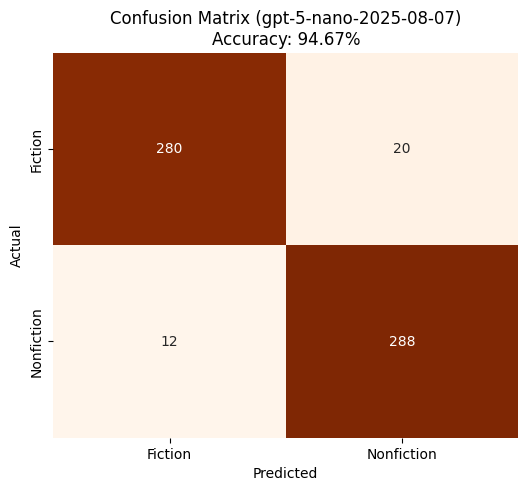

In [ ]:
# Visualization
acc_nano = accuracy_score(y_true_nano, y_pred_nano)
cm_nano = confusion_matrix(y_true_nano, y_pred_nano, labels=["Fiction", "Nonfiction"])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_nano, annot=True, fmt="d", cmap="Oranges", cbar=False,
    xticklabels=["Fiction", "Nonfiction"], yticklabels=["Fiction", "Nonfiction"]
)
ax.set_title(f"Confusion Matrix ({CHEAP_MODEL})\nAccuracy: {acc_nano:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")

plt.tight_layout()
plt.show()

In [46]:
LARGE_MODEL = "deepseek/deepseek-v3.2-speciale"

# Run Classification
print(f"Loading Large Model: {LARGE_MODEL}...")
preds_fic_ds, actuals_fic_ds = run_batch_classification(
    sequences_fic,
    "Fiction",
    model_name=LARGE_MODEL,
    schema=BookClassification,
    max_workers=15
)

preds_non_ds, actuals_non_ds = run_batch_classification(
    sequences_non,
    "Nonfiction",
    model_name=LARGE_MODEL,
    schema=BookClassification,
    max_workers=15
)

# Aggregation & Cleaning
all_preds_ds = preds_fic_ds + preds_non_ds
all_actuals_ds = actuals_fic_ds + actuals_non_ds

# Filter out API errors
clean_data_ds = [(t, p) for t, p in zip(all_actuals_ds, all_preds_ds) if p != "Error"]
y_true_ds = [x[0] for x in clean_data_ds]
y_pred_ds = [x[1] for x in clean_data_ds]

error_count = len(all_preds_ds) - len(y_pred_ds)
if error_count > 0:
    print(f"\nNote: {error_count} requests failed and were excluded from metrics.")

# Metrics
print("\nClassification Report:\n")
print(classification_report(y_true_ds, y_pred_ds))

Loading Large Model: deepseek/deepseek-v3.2-speciale...


[deepseek-v3.2-speciale] Classifying Nonfiction: 100%|██████████| 300/300 [04:24<00:00,  1.14it/s]


Classification Report:

              precision    recall  f1-score   support

     Fiction       0.97      0.95      0.96       300
  Nonfiction       0.95      0.97      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



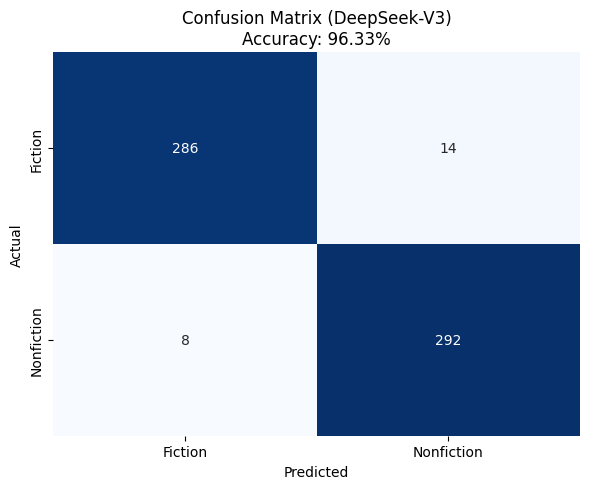

In [ ]:
cm_ds = confusion_matrix(y_true_ds, y_pred_ds, labels=["Fiction", "Nonfiction"])
acc_ds = accuracy_score(y_true_ds, y_pred_ds)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_ds,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Fiction", "Nonfiction"],
    yticklabels=["Fiction", "Nonfiction"]
)
ax.set_title(f"Confusion Matrix (DeepSeek-V3)\nAccuracy: {acc_ds:.2%}")
ax.set(xlabel="Predicted", ylabel="Actual")

plt.tight_layout()
plt.show()

In [ ]:
missing_mask = books["simple_categories"].isna()
missing_books = books[missing_mask].copy()

if len(missing_books) > 0:
    # Run Batch Classification
    sequences = missing_books["description"].tolist()

    print(f"Starting batch prediction for {len(sequences)} items...")

    new_preds, _ = run_batch_classification(
        sequences,
        label="Unknown",
        max_workers=20,
    )

    # Assign Results Back to DataFrame
    # Map the predictions directly to the matching indices in the original dataframe
    books.loc[missing_mask, "simple_categories"] = new_preds

    # If any API calls failed (returned "Error")
    error_count = (books.loc[missing_mask, "simple_categories"] == "Error").sum()
    if error_count > 0:
        print(f"Warning: {error_count} predictions failed (marked as 'Error').")

else:
    print("No missing categories found!")

Starting batch prediction for 1454 items...


Classifying Unknown: 100%|██████████| 1454/1454 [41:38<00:00,  1.72s/it]


In [ ]:
output_filename = "books_with_categories.csv"
books.to_csv(output_filename, index=False)

print(books.loc[missing_mask, ["title", "simple_categories"]].head())

                    title simple_categories
1            Spider's Web           Fiction
3          The Four Loves        Nonfiction
4     The Problem of Pain           Fiction
5  Empires of the Monsoon           Fiction
6    The Gap Into Madness           Fiction
